In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

In [8]:

# notebooks/example_notebook.ipynb

import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [9]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from sql_queries import execute_telecom_queries


In [10]:
# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [13]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

c:\Users\hp\Desktop\10Academy\TellCo-Investment-Analysis\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [14]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


### Aggregate Metrics Per Customer

In [32]:
aggregated_data = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  
    'Dur. (ms)': 'sum',  
    'Total DL (Bytes)': 'sum',  
    'Total UL (Bytes)': 'sum'   
}).reset_index()

# Renaming columns for clarity
aggregated_data.rename(columns={'Bearer Id': 'Session Count'}, inplace=True)

# Calculating total traffic
aggregated_data['Total Traffic'] = aggregated_data['Total DL (Bytes)'] + aggregated_data['Total UL (Bytes)']

In [41]:
print(aggregated_data)

        MSISDN/Number  Session Count  Dur. (ms)  Total DL (Bytes)  \
0        3.360100e+10              1   116720.0      8.426375e+08   
1        3.360100e+10              1   181230.0      1.207552e+08   
2        3.360100e+10              1   134969.0      5.566597e+08   
3        3.360101e+10              1    49878.0      4.019932e+08   
4        3.360101e+10              2    37104.0      1.363130e+09   
...               ...            ...        ...               ...   
106851   3.379000e+10              1     8810.0      6.879252e+08   
106852   3.379000e+10              1   140988.0      4.445751e+08   
106853   3.197021e+12              1   877385.0      1.948281e+08   
106854   3.370000e+14              1   253030.0      5.396350e+08   
106855   8.823971e+14              1   869844.0      7.869760e+07   

        Total UL (Bytes)  Total Traffic  Cluster  
0             36053108.0   8.786906e+08        2  
1             36104459.0   1.568596e+08        2  
2             3930

In [43]:
# Report the top 10 customers per metric
top_10_sessions = aggregated_data.nlargest(10, 'Session Count')
top_10_duration = aggregated_data.nlargest(10, 'Dur. (ms)')
top_10_traffic = aggregated_data.nlargest(10, 'Total Traffic')

# Show the top 10 customers per metric
print("Top 10 Customers by Sessions Frequency:")
print(top_10_sessions[['MSISDN/Number', 'Session Count']])

print("Top 10 Customers by Session Duration:")
print(top_10_duration[['MSISDN/Number', 'Dur. (ms)']])

Top 10 Customers by Sessions Frequency:
       MSISDN/Number  Session Count
13526   3.362632e+10             18
6437    3.361489e+10             17
13180   3.362578e+10             17
37052   3.365973e+10             16
76363   3.367588e+10             15
92923   3.376054e+10             15
65118   3.366716e+10             13
666     3.360313e+10             12
1279    3.360452e+10             12
13994   3.362708e+10             12
Top 10 Customers by Session Duration:
       MSISDN/Number   Dur. (ms)
13180   3.362578e+10  18553754.0
6437    3.361489e+10   9966898.0
92923   3.376054e+10   9279434.0
13526   3.362632e+10   8791927.0
65118   3.366716e+10   8744914.0
50281   3.366284e+10   6614270.0
57160   3.366469e+10   6288730.0
666     3.360313e+10   6287761.0
66029   3.366746e+10   5649882.0
92577   3.376041e+10   5321667.0


### Normalize Metrics and Apply Clustering

In [33]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(aggregated_data[['Session Count', 'Dur. (ms)', 'Total Traffic']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(normalized_data)


Cluster Summary Statistics:
  Cluster Session Count                      Dur. (ms)              \
                    min max      mean    sum       min         max   
0       0             1   4  2.184791  46228   18235.0   3174824.0   
1       1             3  18  4.258194  17020   49323.0  18553754.0   
2       2             0   2  1.043550  85258    7142.0   1573420.0   

                               Total Traffic                              \
            mean           sum           min           max          mean   
0  215100.806229  4.551318e+09  2.842182e+08  1.915933e+09  1.138979e+09   
1  572159.112084  2.286920e+09  1.085994e+09  8.846226e+09  2.294204e+09   
2  107473.680857  8.780600e+09  3.324901e+07  1.427100e+09  4.964976e+08   

                 
            sum  
0  2.409966e+13  
1  9.169934e+12  
2  4.056385e+13  


<Figure size 1200x600 with 0 Axes>

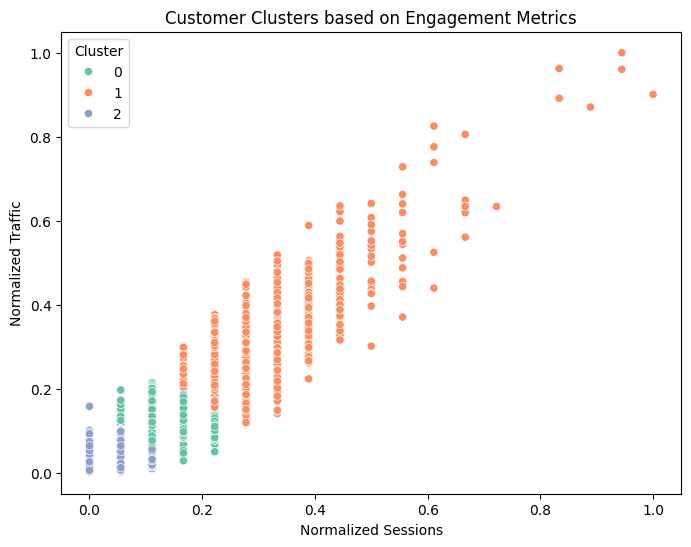

In [46]:
# Select the relevant metrics for clustering
metrics = aggregated_data[['Session Count', 'Dur. (ms)', 'Total Traffic']]

# Normalize the metrics using Min-Max Scaling
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(metrics)

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Add normalized metrics back to the dataframe for visualization
aggregated_data['Normalized Sessions'] = normalized_metrics[:, 0]
aggregated_data['Normalized Duration'] = normalized_metrics[:, 1]
aggregated_data['Normalized Traffic'] = normalized_metrics[:, 2]

# Summary statistics for each cluster
cluster_summary = aggregated_data.groupby('Cluster').agg({
    'Session Count': ['min', 'max', 'mean', 'sum'],
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic': ['min', 'max', 'mean', 'sum']
}).reset_index()

print("Cluster Summary Statistics:")
print(cluster_summary)

# Visualize the clustering results
plt.figure(figsize=(12, 6))


# Scatter plot to visualize customer clusters based on normalized metrics
plt.figure(figsize=(8, 6))
sns.scatterplot(data=aggregated_data, x='Normalized Sessions', y='Normalized Traffic', hue='Cluster', palette='Set2')
plt.title('Customer Clusters based on Engagement Metrics')
plt.show()


### Optimize K (Elbow Method)

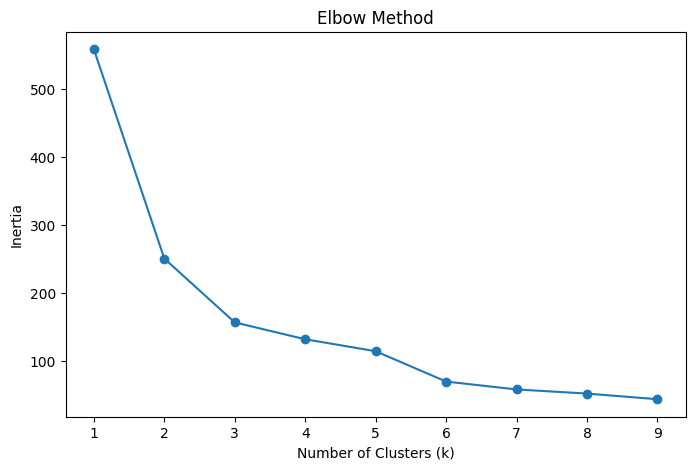

In [36]:
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


### Aggregate Traffic Per Application

Aggregated Traffic Per Application:
                Application  Total Traffic (Bytes)
10        Gaming DL (Bytes)           6.330713e+13
12         Other DL (Bytes)           6.316550e+13
6        Youtube DL (Bytes)           1.745123e+12
8        Netflix DL (Bytes)           1.744039e+12
7        Youtube UL (Bytes)           1.651423e+12
9        Netflix UL (Bytes)           1.650274e+12
11        Gaming UL (Bytes)           1.243268e+12
13         Other UL (Bytes)           1.239728e+12
2         Google DL (Bytes)           8.626186e+11
3         Google UL (Bytes)           3.084833e+11
0   Social Media DL (Bytes)           2.693001e+11
4          Email DL (Bytes)           2.687611e+11
5          Email UL (Bytes)           7.010648e+10
1   Social Media UL (Bytes)           4.939298e+09


C:\Users\hp\AppData\Local\Temp\ipykernel_16572\3275931247.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_app_traffic, x='Application', y='Total Traffic (Bytes)', palette='viridis')


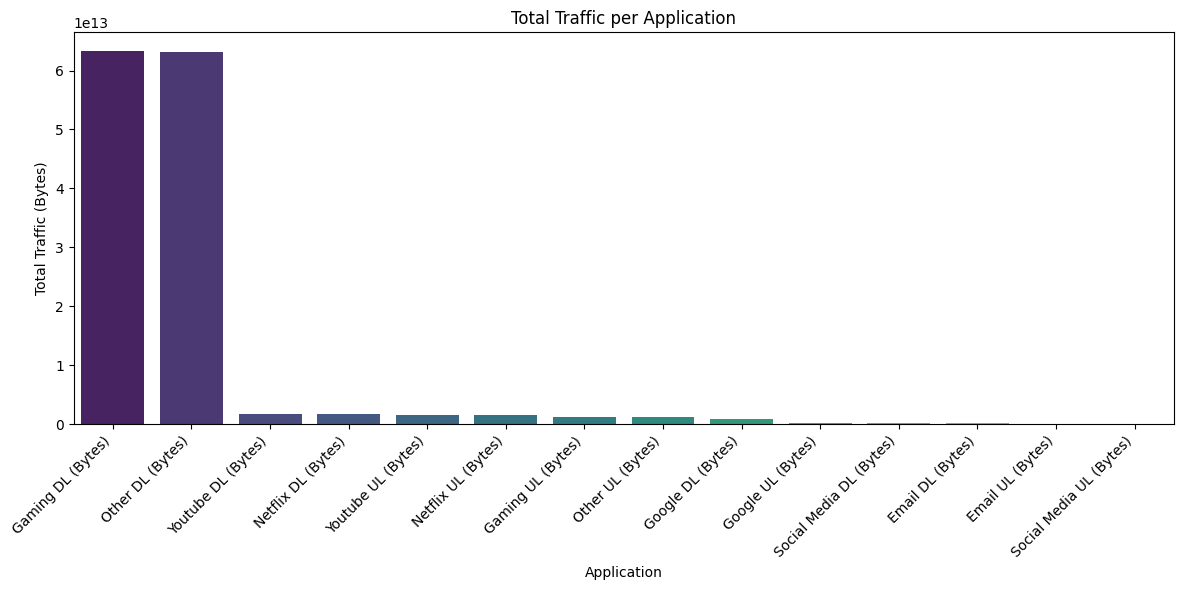

In [47]:
import pandas as pd

# Assuming 'df' is your dataframe
# Example of loading your data
# df = pd.read_csv('your_data.csv')

# Step 1: Aggregate Traffic Metrics per Customer (MSISDN/Number)
aggregated_data = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  # Counting unique sessions
    'Dur. (ms)': 'sum',  # Summing session durations
    'Total DL (Bytes)': 'sum',  # Summing download traffic
    'Total UL (Bytes)': 'sum'   # Summing upload traffic
}).reset_index()

# Renaming columns for clarity
aggregated_data.rename(columns={'Bearer Id': 'Session Count'}, inplace=True)

# Calculating total traffic per customer
aggregated_data['Total Traffic'] = aggregated_data['Total DL (Bytes)'] + aggregated_data['Total UL (Bytes)']

# Step 2: Aggregate Traffic Per Application
# List of application columns (download and upload)
app_columns = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Aggregate total traffic for each application (sum of DL and UL traffic)
app_traffic = df[app_columns].sum(axis=0).reset_index()
app_traffic.columns = ['Application', 'Total Traffic (Bytes)']

# Sorting traffic data by total traffic in descending order
sorted_app_traffic = app_traffic.sort_values(by='Total Traffic (Bytes)', ascending=False)

# Display the aggregated traffic per application
print("Aggregated Traffic Per Application:")
print(sorted_app_traffic)

# Optionally, visualize the result using a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_app_traffic, x='Application', y='Total Traffic (Bytes)', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Total Traffic per Application')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.tight_layout()
plt.show()
